In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
import random

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [3]:
root = '../input/planets-dataset/planet/planet'

In [4]:
assert os.path.exists(root)

In [5]:
train_dir = '../input/planets-dataset/planet/planet/train-jpg/'
test_1_dir =  '../input/planets-dataset/planet/planet/test-jpg/'
test_2_dir = '../input/planets-dataset/test-jpg-additional/'

train_class_file = '../input/planets-dataset/planet/planet/train_classes.csv'
sample_submission_file = '../input/planets-dataset/planet/planet/sample_submission.csv'


#assertions/tests
assert os.path.exists(train_dir), 'train dir not found'
assert os.path.exists(test_1_dir), 'test_1_dir not found'
assert os.path.exists(test_2_dir), 'test_2_dir not found'
assert os.path.exists(train_class_file), 'train_class_file not found'
assert os.path.exists(sample_submission_file), 'sample_submission_file not found'

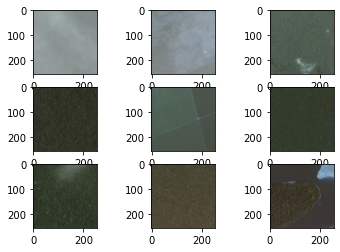

In [6]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = cv2.imread(train_dir + random.choice(os.listdir(train_dir)))
    plt.imshow(image)
plt.show()

In [7]:
train_classes_df = pd.read_csv(train_class_file)
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
sample_submission_df = pd.read_csv(sample_submission_file)
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


We would need to perform two things on the train data frame:
* find all unqiue labels in the dataset
* append .jpg to each image so we can use flow from dataframe to create an image generator

In [9]:
unique_labels = set()

def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)
        
        
train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['cloudy', 'haze', 'primary', 'slash_burn', 'clear', 'blooming', 'conventional_mine', 'selective_logging', 'bare_ground', 'road', 'water', 'blow_down', 'partly_cloudy', 'habitation', 'cultivation', 'artisinal_mine', 'agriculture']


for our one hot encoding we want to create a column for each unique tag

In [10]:
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
train_classes.head()

,image_name,tags,cloudy,haze,primary,slash_burn,clear,blooming,conventional_mine,selective_logging,bare_ground,road,water,blow_down,partly_cloudy,habitation,cultivation,artisinal_mine,agriculture
0,train_0,haze primary,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,train_2,clear primary,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1


In [11]:
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: x+'.jpg')
train_classes.head()

,image_name,tags,cloudy,haze,primary,slash_burn,clear,blooming,conventional_mine,selective_logging,bare_ground,road,water,blow_down,partly_cloudy,habitation,cultivation,artisinal_mine,agriculture
0,train_0.jpg,haze primary,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,train_2.jpg,clear primary,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1


In [12]:
y_col = list(train_classes.columns[2:])
y_col

['cloudy',
 'haze',
 'primary',
 'slash_burn',
 'clear',
 'blooming',
 'conventional_mine',
 'selective_logging',
 'bare_ground',
 'road',
 'water',
 'blow_down',
 'partly_cloudy',
 'habitation',
 'cultivation',
 'artisinal_mine',
 'agriculture']

In [13]:
def fbeta(ytrue, ypred, beta=2, epsilon=1e-4):
    beta_squared = beta**2
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1 + beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)
    
    return fb

In [14]:
def multi_label_acc(ytrue, ypred, epsilon=1e-4):
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32), axis=1 )
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [15]:
# Image genrator
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)

#generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes,\
                                               directory=train_dir,\
                                               x_col='image_name', y_col=y_col,\
                                               target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')
# generating 20% validation images
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes,\
                                               directory=train_dir,\
                                               x_col='image_name', y_col=y_col,\
                                               target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [16]:
train_gen[0][1][1] #viewing the label of the second image in the dataframe

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [17]:
#setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples/train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples/val_gen.batch_size))

In [18]:
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=[128, 128, 3], padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'))

    model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'))

    model.add(tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(17, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[multi_label_acc,fbeta])
    return model

In [19]:
save_best_check_point = ModelCheckpoint(filepath='amazon_base_model.hdf5', monitor='val_fbeta',\
                                       mode='max', save_best_only=True, save_weights_only=True)

In [20]:
model1 = build_model()

model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size, epochs=20, callbacks=[save_best_check_point], verbose=1)

Epoch 1/20
253/253 [==============================] - 146s 578ms/step - loss: 0.2247 - multi_label_acc: 0.9110 - fbeta: 0.6732 - val_loss: 0.1831 - val_multi_label_acc: 0.9257 - val_fbeta: 0.7310
Epoch 2/20
253/253 [==============================] - 129s 511ms/step - loss: 0.1670 - multi_label_acc: 0.9335 - fbeta: 0.7771 - val_loss: 0.1511 - val_multi_label_acc: 0.9408 - val_fbeta: 0.8109
Epoch 3/20
253/253 [==============================] - 130s 513ms/step - loss: 0.1487 - multi_label_acc: 0.9408 - fbeta: 0.8049 - val_loss: 0.1385 - val_multi_label_acc: 0.9453 - val_fbeta: 0.8167
Epoch 4/20
253/253 [==============================] - 130s 512ms/step - loss: 0.1378 - multi_label_acc: 0.9451 - fbeta: 0.8224 - val_loss: 0.1336 - val_multi_label_acc: 0.9472 - val_fbeta: 0.8315
Epoch 5/20
253/253 [==============================] - 130s 515ms/step - loss: 0.1288 - multi_label_acc: 0.9485 - fbeta: 0.8373 - val_loss: 0.1346 - val_multi_label_acc: 0.9477 - val_fbeta: 0.8415
Epoch 6/20
253/253 [

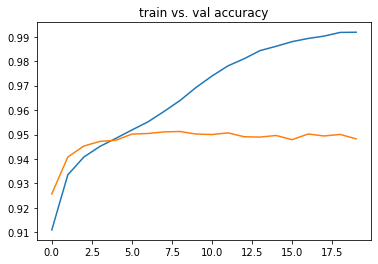

In [22]:
plt.plot(model1.history.history['multi_label_acc'])
plt.plot(model1.history.history['val_multi_label_acc'])
plt.title('train vs. val accuracy')
plt.show()

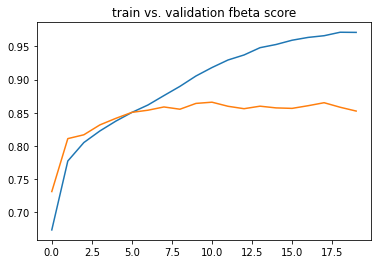

In [23]:
plt.plot(model1.history.history['fbeta'])
plt.plot(model1.history.history['val_fbeta'])
plt.title('train vs. validation fbeta score')
plt.show()

In [24]:
model2 = build_model()

#loading in the weights of the trained model
model2.load_weights('amazon_base_model.hdf5')

In [25]:
#adding a .jpg extension to 'image_name' in sample_submission data
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [26]:
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)

test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [27]:
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df,\
                                               directory='../input/planets-dataset/planet/planet/test-jpg',\
                                               x_col='image_name', y_col=None,\
                                               batch_size=128, shuffle=False, class_mode=None, target_size=(128,128))
#setting the step size for the testing set

step_test_size1 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 40669 validated image filenames.


In [28]:
test_gen1.reset() #double checking to avoid shuffling
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) #predicts the first 40669 images in the sample submisiion dataframe

318/318 [==============================] - 129s 404ms/step


In [30]:
test_file_names1 = test_gen1.filenames

#converting
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(list(unique_labels))[x>0.5]), axis=1)

#converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags':pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy


In [32]:
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [33]:
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df,\
                                               directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional',\
                                               x_col='image_name', y_col=None,\
                                               batch_size=128, shuffle=False, class_mode=None, target_size=(128,128))
#setting the step size for the testing set

step_test_size2 = int(np.ceil(test_gen2.samples/test_gen2.batch_size))

Found 20522 validated image filenames.


In [34]:
test_gen2.reset() #double checking to avoid shuffling
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) #predicts from 40669 to the end images in the sample submisiion dataframe

161/161 [==============================] - 64s 398ms/step


In [37]:
test_file_names2 = test_gen2.filenames

#converting
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(list(unique_labels))[x>0.5]), axis=1)

#converting the predictions of the first 40669 to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags':pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,primary partly_cloudy agriculture
2,file_10.jpg,haze primary road water
3,file_100.jpg,primary clear agriculture
4,file_1000.jpg,primary clear


In [38]:
final_result = pd.concat([result1, result2])

final_result = final_result.reset_index().drop('index', axis=1)

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy


In [40]:
#remove the .jpg

final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])

In [42]:
final_result.shape

(61191, 2)

In [43]:
#sum(sample_submission['image_name'] == final_result['image_name'])

0

In [44]:
sample_submission['image_name'].head()

0    test_0.jpg
1    test_1.jpg
2    test_2.jpg
3    test_3.jpg
4    test_4.jpg
Name: image_name, dtype: object

In [45]:
final_result['image_name'].head()

0    test_0
1    test_1
2    test_2
3    test_3
4    test_4
Name: image_name, dtype: object

In [46]:
assert sum(sample_submission['image_name'].apply(lambda x: x[:-4]) == final_result['image_name']) == 61191

In [47]:
#export results
#final_result.to_csv('amazon_baseline_submission.csv', index=False)

# Data Augmentation

In [49]:
# Image genrator
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  horizontal_flip=True, 
                                                                  vertical_flip=True,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  zoom_range=0.2,
                                                                  shear_range=0.1,
                                                                  rotation_range=90,
                                                                  validation_split=0.2)


#generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes,\
                                               directory=train_dir,\
                                               x_col='image_name', y_col=y_col,\
                                               target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')
# generating 20% validation images
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes,\
                                               directory=train_dir,\
                                               x_col='image_name', y_col=y_col,\
                                               target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [51]:
save_best_check_point = ModelCheckpoint(filepath='amazon_aug_model.hdf5', monitor='val_fbeta',\
                                       mode='max', save_best_only=True, save_weights_only=True)

In [52]:
model1 = build_model()

model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size, epochs=20, callbacks=[save_best_check_point], verbose=1)

Epoch 1/20
253/253 [==============================] - 297s 1s/step - loss: 0.2300 - multi_label_acc: 0.9080 - fbeta: 0.6638 - val_loss: 0.2055 - val_multi_label_acc: 0.9199 - val_fbeta: 0.7235
Epoch 2/20
253/253 [==============================] - 291s 1s/step - loss: 0.1864 - multi_label_acc: 0.9268 - fbeta: 0.7480 - val_loss: 0.1681 - val_multi_label_acc: 0.9362 - val_fbeta: 0.7813
Epoch 3/20
253/253 [==============================] - 279s 1s/step - loss: 0.1657 - multi_label_acc: 0.9348 - fbeta: 0.7818 - val_loss: 0.1533 - val_multi_label_acc: 0.9388 - val_fbeta: 0.7985
Epoch 4/20
253/253 [==============================] - 283s 1s/step - loss: 0.1526 - multi_label_acc: 0.9398 - fbeta: 0.8012 - val_loss: 0.1417 - val_multi_label_acc: 0.9438 - val_fbeta: 0.8243
Epoch 5/20
253/253 [==============================] - 272s 1s/step - loss: 0.1443 - multi_label_acc: 0.9432 - fbeta: 0.8153 - val_loss: 0.1354 - val_multi_label_acc: 0.9469 - val_fbeta: 0.8259
Epoch 6/20
253/253 [===============

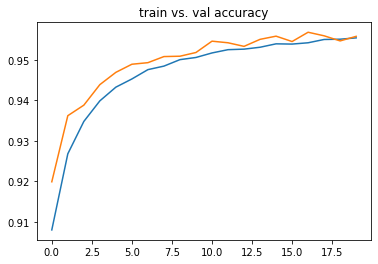

In [53]:
plt.plot(model1.history.history['multi_label_acc'])
plt.plot(model1.history.history['val_multi_label_acc'])
plt.title('train vs. val accuracy')
plt.show()

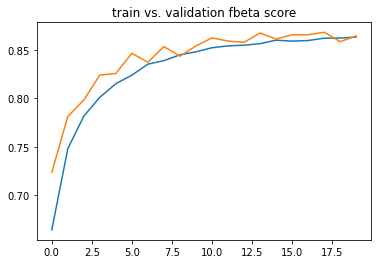

In [54]:
plt.plot(model1.history.history['fbeta'])
plt.plot(model1.history.history['val_fbeta'])
plt.title('train vs. validation fbeta score')
plt.show()

The model seems to have performed better on the validation set, suggesting an even better generalization. and only begins to 'overfit' somewhere around the 16th epoch

In [55]:
model2 = build_model()

#loading in the weights of the trained model
model2.load_weights('amazon_aug_model.hdf5')

In [56]:
#adding a .jpg extension to 'image_name' in sample_submission data
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))

test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)

test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df,\
                                               directory='../input/planets-dataset/planet/planet/test-jpg',\
                                               x_col='image_name', y_col=None,\
                                               batch_size=128, shuffle=False, class_mode=None, target_size=(128,128))
#setting the step size for the testing set

step_test_size1 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

test_gen1.reset() #double checking to avoid shuffling
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) #predicts the first 40669 images in the sample submisiion dataframe

Found 40669 validated image filenames.
318/318 [==============================] - 120s 377ms/step


In [57]:
test_file_names1 = test_gen1.filenames

#converting
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(list(unique_labels))[x>0.5]), axis=1)

#converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags':pred_tags1})

In [58]:
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)


test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df,\
                                               directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional',\
                                               x_col='image_name', y_col=None,\
                                               batch_size=128, shuffle=False, class_mode=None, target_size=(128,128))
#setting the step size for the testing set

step_test_size2 = int(np.ceil(test_gen2.samples/test_gen2.batch_size))


test_gen2.reset() #double checking to avoid shuffling
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) #predicts from 40669 to the end images in the sample submisiion dataframe

Found 20522 validated image filenames.
161/161 [==============================] - 56s 348ms/step


In [59]:
test_file_names2 = test_gen2.filenames

#converting
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(list(unique_labels))[x>0.5]), axis=1)

#converting the predictions of the first 40669 to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags':pred_tags2})


final_result = pd.concat([result1, result2])

final_result = final_result.reset_index().drop('index', axis=1)

print(final_result.shape)

(61191, 2)


In [60]:
#remove the .jpg

final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])

assert sum(sample_submission['image_name'].apply(lambda x: x[:-4]) == final_result['image_name']) == 61191

In [61]:
#export results
#final_result.to_csv('amazon_augVersion_submission.csv', index=False)